## Data preprocessing

#### data cleaning

In [ ]:
import pandas as pd
# load original dataset
data_original = pd.read_csv("/content/billboard_24years_lyrics_spotify.csv")
print(data_original.head(10))

   ranking                 song       band_singer  \
0        1              Breathe        Faith Hill   
1        2               Smooth           Santana   
2        2               Smooth        Rob Thomas   
3        3          Maria Maria           Santana   
4        3          Maria Maria   The Product G&B   
5        4         I Wanna Know               Joe   
6        5  Everything You Want  Vertical Horizon   
7        6          Say My Name   Destiny's Child   
8        7   I Knew I Loved You     Savage Garden   
9        8               Amazed          Lonestar   

                                             songurl            titletext  \
0                    /wiki/Breathe_(Faith_Hill_song)              Breathe   
1                        /wiki/Smooth_(Santana_song)               Smooth   
2                        /wiki/Smooth_(Santana_song)               Smooth   
3                                  /wiki/Maria_Maria          Maria Maria   
4                              

In [ ]:
# delete duplicate rows based on the 'lyrics' column
data= data_original.drop_duplicates(subset="lyrics")

# Reset the index after dropping rows
data = data.reset_index(drop=True)

print("Number of rows in cleaned dataset:", data.shape[0])

Number of rows in cleaned dataset: 2330


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# save results to csv
data.to_csv('/content/drive/MyDrive/01_cleaned_data.csv')

#### data labeling

Run Emotion-English-DistilRoBERTa-base model

In [ ]:
# install the transformers library
!pip install transformers

In [ ]:
# import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    report_to="none"
)

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [ ]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model,args=training_args)

In [ ]:
# choose texts
text_column = "lyrics"
pred_texts = data[text_column].dropna().astype('str').tolist()

Classify texts with model

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts, truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# Run predictions
predictions = trainer.predict(pred_dataset)
print(predictions[:10])

In [ ]:
pred_array = predictions.predictions
label_pred_save = pd.DataFrame(pred_array, columns=[f"label_{i}" for i in range(pred_array.shape[1])])
print("Rows in original data:", data.shape[0])
print("Rows in predictions data:", label_pred_save.shape[0])

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# scores raw
temp = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True))

In [ ]:
# work in progress
# container
anger = []
disgust = []
fear = []
joy = []
neutral = []
sadness = []
surprise = []

# extract scores (as many entries as exist in pred_texts)
for i in range(len(temp)):
  anger.append(temp[i][0])
  disgust.append(temp[i][1])
  fear.append(temp[i][2])
  joy.append(temp[i][3])
  neutral.append(temp[i][4])
  sadness.append(temp[i][5])
  surprise.append(temp[i][6])

In [ ]:
# Check the lengths of each array
print(f"Length of pred_texts: {len(pred_texts)}")
print(f"Length of preds: {len(preds)}")
print(f"Length of labels: {len(labels)}")
print(f"Length of scores: {len(scores)}")
print(f"Length of anger: {len(anger)}")
print(f"Length of disgust: {len(disgust)}")
print(f"Length of fear: {len(fear)}")
print(f"Length of joy: {len(joy)}")
print(f"Length of neutral: {len(neutral)}")
print(f"Length of sadness: {len(sadness)}")
print(f"Length of surprise: {len(surprise)}")


export results

In [ ]:
# Create a new DataFrame for predictions, labels, and scores
pred_df = pd.DataFrame({
     'pred': preds,
    'label': labels,
    'score': scores,
    'anger': anger,
    'disgust': disgust,
    'fear': fear,
    'joy': joy,
    'neutral': neutral,
    'sadness': sadness,
    'surprise': surprise
})

# Combine the original features with the new predictions DataFrame
df_combined = pd.concat([data, pred_df], axis=1)

# Display the first few rows of the combined DataFrame
df_combined.head()


In [ ]:
# save results to csv
df_combined.to_csv('/content/drive/MyDrive/02_labelled_data.csv')

#### dataset overview


In [ ]:

label_counts = df_combined['label'].value_counts()

label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Emotion', 'Count']
print(label_counts_df)

    Emotion  Count
0   neutral    676
1     anger    490
2      fear    482
3   sadness    377
4  surprise    105
5   disgust    105
6       joy     95


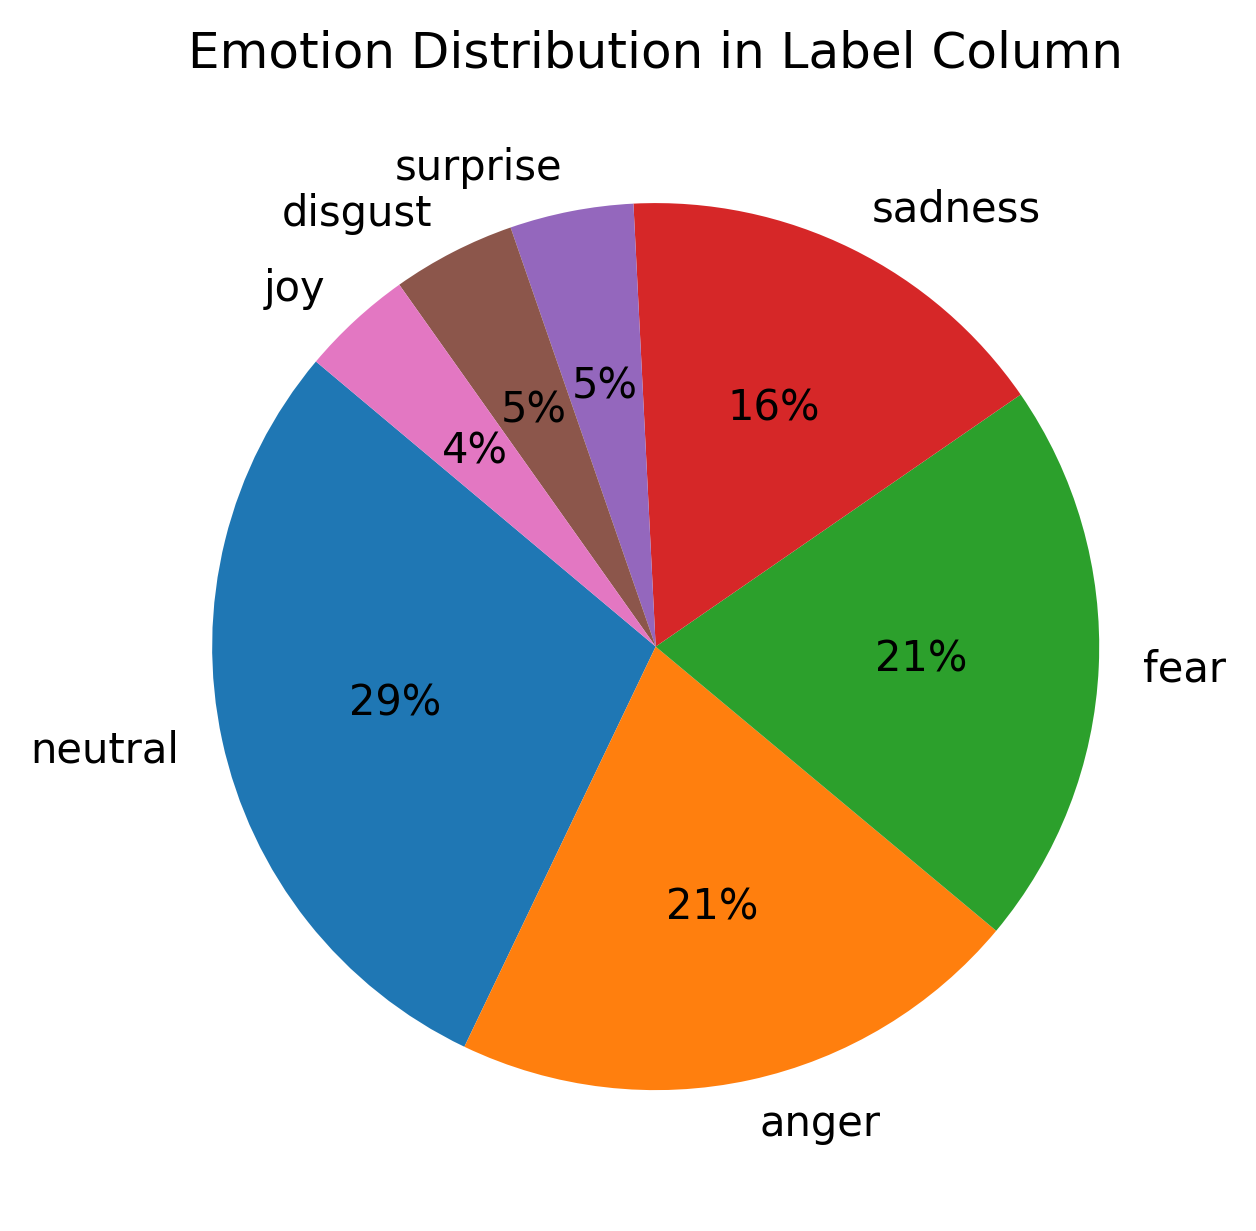

In [ ]:
import matplotlib.pyplot as plt
plt.figure(dpi=300)
plt.pie(label_counts, labels=label_counts.index, autopct='%1.0f%%', startangle=140)
plt.title('Emotion Distribution in Label Column')
plt.show()